# **RYM Interactive Poll Results**

### Available Polls

- **Film Board Ranks the Decades of Cinema: 2010s** (closed)

  Hosted by diction ([RYM List](https://rateyourmusic.com/list/diction/rym-ranks-the-decades-of-cinema-2010s-2021_final-edition/))


- **Film Board Ranks the Decades of Cinema: 2000s** (closed)

  Hosted by Rengar18 ([RYM List](https://rateyourmusic.com/list/Rengar18/film-board-ranks-the-decades-of-cinema-2000s/))

- **Film Board Ranks the Decades of Cinema: 1990s** (closed)

  Hosted by Rengar18 ([RYM List](https://rateyourmusic.com/list/Rengar18/film-board-ranks-the-decades-of-cinema-1990s/))

- **Film Board Ranks the Decades of Cinema: 1980s** (closed)

  Hosted by Rengar18 ([RYM List](https://rateyourmusic.com/list/Rengar18/film-board-ranks-the-decades-of-cinema-1980s/))



### **Instructions**

**You need to be signed into your Google account if you want to interact with the widgets in this notebook.** You also need to accept a scary-looking prompt warning you that this notebook was not authored by Google.

To run the entire notebook: **Runtime -> Run all** (easiest/recommended way to get started)

To run an individual cell: Click on the run button in the top left corner of the cell

To hide code: double click on the rendered area to the right of the code cell.

**Regarding metadata:**

The metadata (cast, crew, language, etc.) was automatically fetched from external databases such as [TMDB.org](https://www.themoviedb.org/). However, since I only have few bits of information as search queries, some of the fetched data is still missing or incorrect (mostly due to works that have similar titles). Fixing this will require manual cleanup. Anyway, film polls will be much simpler once RYM gets its own API (one can always dream...)

# Load Data

In [5]:
#@markdown <- Run this cell to load all datasets. **This is required for any other cells to work** and may take up to 20 seconds.
import math
import numpy as np
import pandas as pd
import requests
import json
import seaborn as sns; sns.set()
import ipywidgets as widgets
from IPython.display import HTML
import gspread
from gspread_dataframe import set_with_dataframe
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import data_table
data_table.enable_dataframe_formatter()

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 16,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'font.family': 'sans-serif'
   }
plt.rcParams.update(params)
palette = sns.color_palette()

# pd.set_option('max_rows', None)
pd.options.display.max_rows = None

layout={'width': '350px'} # Widget layout

###

query_tmdb = False
max_queries = 1000
TOP_ITEMS = 100

###############################################
# Option 1: Load data from Google sheets      #
# Option 2: Load vote matrix csvs from GitHub #
###############################################

"""
The spreadsheet needs two subsheets, named "Votes", "Titles".
The Votes and first two columns of the Titles sheets need to be filled by the user.
The notebook will save the vote matrix as a csv file.
Reference sheet: https://docs.google.com/spreadsheets/d/12QQ6aC2SsDjtlT7u5kcbFiKBAQWU0JA_rq2CEKciwTk/edit?usp=sharing
"""

options = {"default_delimiter": ". ",
          "special_delimiters": ["\) "],
          "load_from_sheet": False,
          "size_dependent_borda": False,
          "remove_original_title": True,
          "database_id": "TMDB_id",
          "finalchar": "]",
          "link": "https://www.themoviedb.org/movie/"}

options_film_2010s = options.copy()
options_film_2010s["dataname"] = 'Film (2010s)'
options_film_2010s["SHEETNAME"] = '2010s Movies'
options_film_2010s["vote_matrix_csv"] = "https://raw.githubusercontent.com/annamjo/interactive_borda/main/data/2010s%20Movies_vote_matrix.csv"
options_film_2010s["titles_csv"] = "https://raw.githubusercontent.com/annamjo/interactive_borda/main/data/2010s%20Movies%20-%20Titles.csv"
options_film_2010s["metacols"] = ['Release','Runtime','Genres','Language','Cast','Director','Producer','Writer','Director of Photography','Editor','Composer','Sound Designer','Art Direction','Production Design','Costume Design','Makeup Artist']
options_film_2010s["type"] = "Film"
options_film_2010s["DEFAULT_RANK_OPTION"] = "BORDA_RANK_CLASSIC"
options_film_2010s["print"] = "ID"

options_film_2000s = options.copy()
options_film_2000s["dataname"] = 'Film (2000s)'
options_film_2000s["SHEETNAME"] = '2000s Movies'
options_film_2000s["vote_matrix_csv"] = "https://raw.githubusercontent.com/annamjo/interactive_borda/main/data/2000s%20Movies_vote_matrix.csv"
options_film_2000s["titles_csv"] = "https://raw.githubusercontent.com/annamjo/interactive_borda/main/data/2000s%20Movies%20-%20Titles.csv"
options_film_2000s["metacols"] = ['Release','Runtime','Genres','Language','Cast','Director','Producer','Writer','Director of Photography','Editor','Composer','Sound Designer','Art Direction','Production Design','Costume Design','Makeup Artist']
options_film_2000s["type"] = "Film"
options_film_2000s["DEFAULT_RANK_OPTION"] = "BORDA_RANK_CLASSIC"
options_film_2000s["print"] = "ID"

options_film_1990s = options.copy()
options_film_1990s["dataname"] = 'Film (1990s)'
options_film_1990s["SHEETNAME"] = '1990s in film'
options_film_1990s["vote_matrix_csv"] = "https://raw.githubusercontent.com/annamjo/interactive_borda/main/data/1990s%20in%20film_vote_matrix.csv"
options_film_1990s["titles_csv"] = "https://raw.githubusercontent.com/annamjo/interactive_borda/main/data/1990s%20in%20film_meta_df.csv"
options_film_1990s["metacols"] = ['Release','Runtime','Genres','Language','Cast','Director','Producer','Writer','Director of Photography','Editor','Composer','Sound Designer','Art Direction','Production Design','Costume Design','Makeup Artist']
options_film_1990s["type"] = "Film"
options_film_1990s["DEFAULT_RANK_OPTION"] = "BORDA_RANK_CLASSIC"
options_film_1990s["print"] = "ID"

options_film_1980s = options.copy()
options_film_1980s["dataname"] = 'Film (1980s)'
options_film_1980s["SHEETNAME"] = '1980s in film'
options_film_1980s["vote_matrix_csv"] = "https://raw.githubusercontent.com/annamjo/interactive_borda/main/data/1980s%20in%20film_vote_matrix.csv"
options_film_1980s["titles_csv"] = "https://raw.githubusercontent.com/annamjo/interactive_borda/main/data/1980s%20in%20film_meta_df.csv"
options_film_1980s["metacols"] = ['Release','Runtime','Genres','Language','Cast','Director','Producer','Writer','Director of Photography','Editor','Composer','Sound Designer','Art Direction','Production Design','Costume Design','Makeup Artist']
options_film_1980s["type"] = "Film"
options_film_1980s["DEFAULT_RANK_OPTION"] = "BORDA_RANK_CLASSIC"
options_film_1980s["print"] = "ID"

options_film_combined = options.copy()
options_film_combined["dataname"] = 'Film (Combined)'
options_film_combined["vote_matrix_csv"] = "https://raw.githubusercontent.com/annamjo/interactive_borda/main/data/combined_film_vote_matrix.csv"
options_film_combined["titles_csv"] = "https://raw.githubusercontent.com/annamjo/interactive_borda/main/data/combined_film_metadata.csv"
options_film_combined["metacols"] = ['Release','Runtime','Genres','Language','Cast','Director','Producer','Writer','Director of Photography','Editor','Composer','Sound Designer','Art Direction','Production Design','Costume Design','Makeup Artist']
options_film_combined["type"] = "Film"
options_film_combined["DEFAULT_RANK_OPTION"] = "BORDA_RANK_CLASSIC"
options_film_combined["print"] = "ID"


options_list = [options_film_2010s,
               options_film_2000s,
               options_film_1990s,
               options_film_1980s,
               options_film_combined]
#options_list2 = [options_film_1980s]
###############################################################
###############################################################
###############################################################

def get_votes_df(votesheet, finalchar="", **options):

  votes = np.array(votesheet.get_all_values())
  votes_df = pd.DataFrame(votes[1:,:], columns=votes[0], index=range(1,len(votes[:,0])))

  # Replace non-breaking white space
  votes_df = votes_df.replace(u'\u00A0',' ', regex=True)

  # Tag unranked votes
  votes_df = votes_df.mask(np.char.startswith(votes_df.values.astype(str), "["), "-1. " + votes_df)

  for voter in votes_df:
    #remove comments after finalchar
    if finalchar != "":
      vvv = votes_df[voter].str.split("]", n=1, expand=True) + "]"
      votes_df[voter] = vvv[0]

  # Replace non-default delimiters
  for sd in options["special_delimiters"]:
    votes_df.replace(sd, options["default_delimiter"], regex=True, inplace=True)

  # Take care of whitespace inconsistencies
  votes_df = votes_df.replace(' ','', regex=True).replace('.\[','. [', regex=True)

  return votes_df.mask(votes_df=="]", "0")

def get_vote_matrix(votes_df):

  vote_matrix = pd.DataFrame()

  for voter in votes_df:
    for i, vote in enumerate(votes_df[voter]):
      if vote == "": break
      try: rank, title = vote.split(". ", 1)
      except ValueError:
        rank, title = i+1, vote.split(". ", 1)[-1]
      title = title.lstrip()
      vote_matrix.loc[title, voter] = rank

  vote_matrix.fillna(0,inplace=True)
  vote_matrix = vote_matrix.astype(pd.SparseDtype("int", 0))
  try: vote_matrix = vote_matrix.drop(["0"])
  except KeyError: pass
  #print('Density:', vote_matrix.sparse.density, '\nvote_matrix.shape', vote_matrix.shape)
  return vote_matrix

def get_titles_df(metasheet):

  titles_arr = np.array(metasheet.get_all_values())
  titles_df = pd.DataFrame(titles_arr[1:,1], index=titles_arr[1:,0], columns=["Title"])
  return titles_df

def get_meta_df(metasheet):

  titles_arr = np.array(metasheet.get_all_values())
  multiindex = [np.array(titles_arr[1:,0]),np.array(titles_arr[1:,1])]
  meta_df = pd.DataFrame(titles_arr[1:,2:], index=multiindex, columns=titles_arr[0,2:])
  meta_df.index.names = ["ID","Title"]
  return meta_df

def get_vote_matrix_titled(vote_matrix, meta_df):

  vote_matrix = vote_matrix.sort_index()

  # Case 1: vote_matrix.index consists of IDs
  meta_df = meta_df.sort_index()

  if np.sum(vote_matrix.index != meta_df.index.get_level_values("ID")) != 0:
    # Case 2: vote_matrix.index consists of titles
    meta_df = meta_df.sort_index(level="Title")
    assert np.sum(vote_matrix.index != meta_df.index.get_level_values("Title")) == 0

  vote_matrix.index = meta_df.index

  return vote_matrix

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def superellipse(x, n=2, a=1, b=1, size=1):
  return b * (size**n - np.abs(x/a)**n)**(1/n)

def linear_pop_multiplier(counts, most_votes, pop_weight):

  theta = np.linspace(-1/most_votes, 1/most_votes, 201)[pop_weight+100]
  b = (1-theta*most_votes)/2
  multipliers = theta * counts + b
  return 2*multipliers

def exp_pop_multiplier(counts, most_votes, pop_weight):

  if pop_weight == 0: return np.ones(len(counts))

  multipliers = 1 + most_votes * np.exp(-(counts-1)**2 / (2*(pop_weight*most_votes)**2))
  multipliers /= 1 + most_votes
  return multipliers

def elliptical_pop_multiplier(counts, most_votes, pop_weight):

  if pop_weight >= 0: # mirror superellipse along vertical axis
    counts = counts + 2 * (most_votes//2 - counts) + 1 + most_votes%2

  n = np.linspace(1, 0.1, 101)[np.abs(pop_weight)]
  multipliers = superellipse(counts-1, n=n, a=1, b=1/most_votes, size=most_votes) # counts-1 to move superellipse upwards
  return 2*multipliers

def get_results_df(vote_matrix, Weight, PopWeight, pop_multiplier, partial_rankings, size_dependent=False, norm_factors=[], cc_dict=[]):

  for v in vote_matrix: vote_matrix[v] = vote_matrix[v].mask(vote_matrix[v]<0,partial_rankings[v].loc["Avg_Unranked_Rank"])
  list_sizes = partial_rankings.loc["Size"] if size_dependent else max(partial_rankings.loc["Size"])

  results = pd.DataFrame(index=vote_matrix.index)
  results["Votes"] = vote_matrix.astype(bool).sum(axis=1)
  MOST_VOTES = max(results["Votes"])

  score_matrix = vote_matrix.mask(vote_matrix>0, superellipse(vote_matrix-1,n=Weight,a=1,b=1,size=list_sizes)) # vm-1 to move superellipse upwards
  results["Score"] = score_matrix.sum(axis=1)

  if len(norm_factors) > 0:
    for cc in cc_dict:
      id = cc_dict[cc].DEFAULT_RANK.index
      results.loc[id, "Score"] *= norm_factors[cc]
      results.loc[id, "Votes"] *= norm_factors[cc]
      MOST_VOTES = max(results["Votes"])

  if pop_multiplier == "vote_pop_multiplier": results["Score"] *= results["Votes"]
  else: results["Score"] *= pop_multiplier(results["Votes"], MOST_VOTES, PopWeight)

  results["Score"] = results["Score"].round(1)
  results["Score"] += 0.00001*results["Votes"] # hacky way of breaking ties by number of votes AND use method="min" for tied votes
  results["Rank"] = results["Score"].rank(ascending=False,method='min').astype(int)
  results["Score"] = results["Score"].round(1)

  return results

def get_votes_df_from_vote_matrix(vote_matrix):
  all_user_votes = []
  for v in vote_matrix:
    all_user_votes.append(pd.Series(vote_matrix[v][vote_matrix[v] > 0].sort_values().index.get_level_values(level="Title"), name=v))
  return pd.concat(all_user_votes, axis=1)

def sheet_updater(gc, SHEETNAME, verbose=False, **options):

  # Load sheets
  votesheet = gc.open(SHEETNAME).worksheet('Votes')
  #chartsheet = gc.open(SHEETNAME).worksheet('Chart')
  metasheet = gc.open(SHEETNAME).worksheet('Titles')

  # Get votes df
  votes_df = get_votes_df(votesheet,**options)
  if verbose: display(votes_df.head())

  # Get vote matrix
  vote_matrix = get_vote_matrix(votes_df)
  if verbose: display(vote_matrix.head())
  if verbose: print("Vote matrix shape:", vote_matrix.shape)

  # Append titles to vote matrix index
  meta_df = get_meta_df(metasheet).sort_index()
  #titles_df = get_titles_df(metasheet)
  if verbose: display(meta_df.head())
  if verbose: print("Meta df shape:", meta_df.shape)

  if len(meta_df) != len(vote_matrix):
    print(len(meta_df),len(vote_matrix))
    a=set(vote_matrix.index) - set(meta_df.index.get_level_values(level="ID"))
    b=set(meta_df.index.get_level_values(level="ID")) - set(vote_matrix.index)
    for title in a: print(title)
    print(len(a),len(b))
    print("\n\n\n")
    for title in b: print(title[0])
    raise Exception("Update meta_df")

  vote_matrix = get_vote_matrix_titled(vote_matrix, meta_df)
  vote_matrix.to_csv(f"/content/drive/MyDrive/{SHEETNAME}_vote_matrix.csv")
  print("Saved vote matrix:", f"/content/drive/MyDrive/{SHEETNAME}_vote_matrix.csv")
  if verbose: display(vote_matrix.head())

  meta_df.to_csv(f"/content/drive/MyDrive/{SHEETNAME}_meta_df.csv")
  print("Saved meta_df:", f"/content/drive/MyDrive/{SHEETNAME}_meta_df.csv")

  return meta_df, vote_matrix


def load_data(load_from_sheet, vote_matrix_string="", **options):

  if load_from_sheet:

    from google.colab import auth
    auth.authenticate_user()

    from google.auth import default
    creds, _ = default()

    gc = gspread.authorize(creds)

    from google.colab import drive
    drive.mount('/content/drive')

    meta_df, vote_matrix = sheet_updater(gc, **options)

  elif vote_matrix_string != "":
    import io
    data = io.StringIO(vote_matrix_string)
    vote_matrix = pd.read_csv(data, sep=",", index_col=[0,1])

  else:
    vote_matrix = pd.read_csv(options["vote_matrix_csv"],index_col=[0,1])
    meta_df = pd.read_csv(options["titles_csv"], index_col=[0,1])

  if options["remove_original_title"]:

    meta_df.sort_index(level="ID",inplace=True)
    vote_matrix.sort_index(level="ID",inplace=True)

    cleaned_title = vote_matrix.index.get_level_values(level="Title")
    cleaned_title = cleaned_title.where(cleaned_title.str[-1:] != ']', cleaned_title.str[:-1].str.split('[').str[1])
    vote_matrix.index.get_level_values(level="Title")
    vote_matrix['Title'] = cleaned_title
    vote_matrix.index = vote_matrix.index.droplevel(level="Title")
    vote_matrix.set_index('Title', append=True, inplace=True)

    meta_df.index = vote_matrix.index

  nantitles = vote_matrix.index.get_level_values(level="Title").to_numpy() != vote_matrix.index.get_level_values(level="Title").to_numpy()
  vote_matrix.index = pd.MultiIndex.from_tuples([(x[0], x[0] if nan else x[1]) for x, nan in zip(vote_matrix.index, nantitles)], names=["ID","Title"])

  vote_matrix_all_ranked = vote_matrix.mask(vote_matrix < 0, 25.5)  # to do: partial rankings here
  all_user_votes = get_votes_df_from_vote_matrix(vote_matrix_all_ranked)

  partial_rankings = get_partial_rankings(vote_matrix, size_dependent=options["size_dependent_borda"])
  #if options["DEFAULT_RANK_OPTION"] =='BORDA_RANK_SIZE_DEPENDENT':
  #  DEFAULT_RANK = get_results_df(vote_matrix, 1, 0, linear_pop_multiplier, list_sizes).sort_values(by="Rank")
  if options["DEFAULT_RANK_OPTION"] =='BORDA_RANK':
    DEFAULT_RANK = get_results_df(vote_matrix, 1, 0, linear_pop_multiplier, partial_rankings, size_dependent=options["size_dependent_borda"]).sort_values(by="Rank")
  else:
    DEFAULT_RANK = get_results_df(vote_matrix, 1, 0, "vote_pop_multiplier", partial_rankings, size_dependent=options["size_dependent_borda"]).sort_values(by="Rank")

  meta_df = meta_df.loc[DEFAULT_RANK.index]

  if query_tmdb:
    query_tmdb_wrapper(DEFAULT_RANK, **options)

  return vote_matrix, vote_matrix_all_ranked, all_user_votes, meta_df, DEFAULT_RANK


##################################
##################################
##################################

def query_tmdb_movie(df, metasheet, max_queries, api_key):

  print("Searching TMDB...")
  low_lim, up_lim = 1980, 1989
  print("DECADE LIMITS HARD CODED:", low_lim, up_lim)

  for i, id in enumerate(df.index):

    if i > max_queries: break
    title = id[1]

    if df.loc[id]["TMDB_id"] == "":
      print("Fetching ID for:", title, i)
      r = requests.get('https://api.themoviedb.org/3/search/movie?api_key='+api_key+'&query='+title)
      parsed = json.loads(r.text)

      try:
        for j, res in enumerate(parsed['results']):
          if low_lim <= int(res['release_date'][:4]) <= up_lim:
            df.loc[id, "TMDB_id"] = int(res['id'])
            break

      except (ValueError, KeyError):
        print(json.dumps(parsed, indent=4, sort_keys=True))
        set_with_dataframe(metasheet, df, include_index=True)

    if len(set([df.loc[id, "Release"],df.loc[id,"IMGID"]]).intersection(set([""]))) > 0:

      print("Fetching metadata for", title)
      r = requests.get('https://api.themoviedb.org/3/movie/'+str(df.loc[id, "TMDB_id"])+'?api_key='+api_key)
      r_credits = requests.get('https://api.themoviedb.org/3/movie/'+str(df.loc[id, "TMDB_id"])+'/credits?api_key='+api_key)
      parsed = json.loads(r.text)
      parsed_credits = json.loads(r_credits.text)

      try:
        parsed_crew = parsed_credits['crew']
        parsed_cast = parsed_credits['cast']

        df.loc[id, "IMGID"] = parsed['poster_path']
        df.loc[id, "Release"] = parsed['release_date']
        df.loc[id, "Runtime"] = parsed['runtime']
        df.loc[id, "Language"] = parsed['original_language']
        df.loc[id, "Genres"] = ','.join([g['name'] for g in parsed['genres']])

        df.loc[id, "Cast"] = ",".join([d["name"] for d in parsed_cast if d["order"] < 5])
        df.loc[id, "Director"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Director"])
        df.loc[id, "Producer"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Producer"])
        df.loc[id, "Writer"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Writer"])
        df.loc[id, "Sound Designer"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Sound Designer"])
        df.loc[id, "Editor"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Editor"])
        df.loc[id, "Director of Photography"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Director of Photography"])
        df.loc[id, "Composer"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Original Music Composer"])
        df.loc[id, "Art Direction"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Art Direction"])
        df.loc[id, "Production Design"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Production Design"])
        df.loc[id, "Costume Design"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Costume Design"])
        df.loc[id, "Makeup Artist"] = ",".join([d["name"] for d in parsed_crew if d["job"] == "Makeup Artist"])

      except KeyError:
        print(json.dumps(parsed, indent=4, sort_keys=True))
        set_with_dataframe(metasheet, df, include_index=True)

  return df

def query_tmdb_wrapper(DEFAULT_RANK, SHEETNAME, **options):

  # from google.colab import auth
  # auth.authenticate_user()

  from google.colab import drive
  drive.mount('/content/drive')

  from google.auth import default
  creds, _ = default()

  gc = gspread.authorize(creds)

  metasheet = gc.open(SHEETNAME).worksheet('Titles')

  with open("/content/drive/MyDrive/tmdb_api_key.txt", "r") as f:
    api_key = f.read()[:-1]

  meta_df_prior = get_meta_df(metasheet).sort_index()
  meta_df_prior["Title"] = DEFAULT_RANK.sort_index().index.get_level_values(level="Title")
  meta_df_prior.index = meta_df_prior.index.droplevel(level="Title")
  meta_df_prior.set_index('Title', append=True, inplace=True)

  ids_to_query = DEFAULT_RANK.sort_values(by="Rank").index.get_level_values(level="ID")
  meta_df_prior = meta_df_prior.loc[ids_to_query]
  meta_df = query_tmdb_movie(meta_df_prior, metasheet, max_queries, api_key)

  set_with_dataframe(metasheet, meta_df, include_index=True)

def get_image_row(cc, preamble, meta_df, DEFAULT_RANK, link, database_id):

  statprint = f"""
  Voters: {len(cc.vote_matrix.columns)} <br>
  Titles: {len(cc.vote_matrix)} <br>
  Votes: {np.sum(np.sum(cc.vote_matrix.astype(bool)))} <br>
  """

  image_row = '<div id="carousel">'
  image_row += f"<div class='slide'><div class='center'><h2 style='text-align:center'>{preamble}<h3 style='text-align:center'>{statprint}</div></div>"
  for index in meta_df.index:
    image_row += '<div class="slide">'
    try:
      image_row += f"<h1 style='text-align:center'>{DEFAULT_RANK['Rank'].loc[index]}</h1><p style='text-align:center'>Score: {DEFAULT_RANK['Score'].loc[index]:.0f} | Votes: {DEFAULT_RANK['Votes'].loc[index]}<br></p>"
      image_row += '<a href='+link+str(int(meta_df.loc[index,database_id]))+' target = blank_>'
      image_row += '<img src="https://image.tmdb.org/t/p/w600_and_h900_bestv2'
      image_row += str(meta_df.loc[index,'IMGID']) + '" alt = "' + str(index[1]) + '" style="width:200px"></a>'
    except ValueError:
      print("image row value error:", index)
      pass
    image_row += "</div>"
  image_row += '</div>'
  return image_row

def display_image_carousel(cc, TOP_ITEMS, preamble=""):

  image_row = get_image_row(cc, preamble, cc.meta_df[:TOP_ITEMS], cc.DEFAULT_RANK[:TOP_ITEMS], cc.options["link"], cc.options["database_id"])

  display(HTML("""

  <style>

  #carousel {
      background-color: #ffffff00;
      overflow: visible;
      white-space:nowrap;
  }

  #carousel .slide {
      display: inline-block;
      padding: 5px;
  }

  #carousel .center {
    margin: 0;
    position: relative;
    top: 50%;
    left: 5%;
    transform: translate(-10%,-100%);
  }

  </style>"""+image_row))

class CompiledCharts:

  def __init__(self, load_from_sheet, **options):

    vote_matrix, vote_matrix_all_ranked, all_user_votes, meta_df, DEFAULT_RANK = load_data(load_from_sheet, **options)

    self.vote_matrix = vote_matrix
    self.vote_matrix_all_ranked = vote_matrix_all_ranked # unranked votes replaced with median vote
    self.all_user_votes = all_user_votes # df of ranked vote lists
    self.meta_df = meta_df
    self.DEFAULT_RANK = DEFAULT_RANK
    self.options = options

    self.MAX_LENGTH = int(np.max(self.vote_matrix.values)) # Maximum list length
    self.COUNTS = self.vote_matrix.astype(bool).sum(axis=1)
    self.MOST_VOTES_TITLE = self.COUNTS.sort_values().index[-1][1]
    self.MOST_VOTES = max(self.COUNTS) # Number of votes of most voted entry

    self.vmc_ranked = self.vote_matrix_all_ranked.mask(self.vote_matrix_all_ranked>0, self.MAX_LENGTH+1-self.vote_matrix_all_ranked).corr()
    self.vmc_unranked = self.vote_matrix_all_ranked.mask(self.vote_matrix_all_ranked>0, 1).corr()
    self.voters = list(self.vote_matrix_all_ranked.columns)
    self.list_sizes = get_list_sizes_from_vote_matrix(self.vote_matrix)
    self.partial_rankings = get_partial_rankings(self.vote_matrix,options["size_dependent_borda"])

  def set_clusters(self, cluster_df, cluster_list):
    self.cluster_df = cluster_df,
    self.cluster_list = cluster_list

  def set_links(self):
    self.links_ranked = self.vmc_ranked.stack().reset_index()
    self.links_unranked = self.vmc_ranked.stack().reset_index()
    self.links_ranked.columns = self.links_unranked.columns = ['var1', 'var2', 'value']

  def add_chart_voter(self):
    """Used to add chart voter. Generic new voter cannot have new titles"""
    chart_voter = self.DEFAULT_RANK[:self.MAX_LENGTH].index.get_level_values(level="ID").to_list()
    chart_voter = pd.Series(chart_voter,index=(range(1,len(chart_voter)+1)))
    self.vote_matrix_expanded, self.vote_matrix = add_voter_to_vote_matrix(self.vote_matrix_all_ranked, chart_voter, name=f"Top {self.MAX_LENGTH} Classic")
    self.all_user_votes_expanded, self.all_user_votes = add_voter_to_all_user_votes(self.vote_matrix_all_ranked, self.all_user_votes, chart_voter, name=f"Top {self.MAX_LENGTH} Classic")
    self.vmc_ranked_expanded = self.vote_matrix_expanded.mask(self.vote_matrix_expanded>0, self.MAX_LENGTH+1-self.vote_matrix_expanded).corr()
    self.vmc_unranked_expanded = self.vote_matrix_expanded.mask(self.vote_matrix_expanded>0, 1).corr()
    self.voters_expanded = list(self.vote_matrix_expanded.columns)

def get_list_sizes_from_vote_matrix(vote_matrix):
  """
  Needed for size-dependent Borda count
  Cannot use all_user_votes because it doesn't contain info on which lists are unranked
  """
  return vote_matrix.astype(bool).sum(axis=0)

def get_partial_rankings(vote_matrix, size_dependent=False):
  """
  Counts ballot sizes, number of ranked and unranked items,
  avg rank of unranked items (=25.5 for completely unranked list of size 50)
  """
  if size_dependent:
    size = vote_matrix.astype(bool).sum(axis=0)
  else:
    size = pd.Series([max(vote_matrix.max(axis=1)) for _ in range(len(vote_matrix.columns))], index=vote_matrix.columns)

  unranked = np.abs(vote_matrix.mask(vote_matrix>0,0).sum(axis=0))
  ranked = size - unranked
  avg_rank = 1+ranked+(unranked-1)/2
  df = pd.DataFrame([size.values,ranked.values,unranked.values,avg_rank.values],index=["Size","Ranked","Unranked","Avg_Unranked_Rank"],columns=size.index)
  df.loc["Avg_Unranked_Rank"] = df.loc["Avg_Unranked_Rank"].mask(df.loc["Unranked"]==0,0)
  #print("rounding unranked ballots")
  df.loc["Avg_Unranked_Rank"] = df.loc["Avg_Unranked_Rank"].round(0).astype(int) # rounding rank up to 26 => rounding points down to 25
  return df

def add_voter_to_vote_matrix(vote_matrix, vote_list, name=""):
  """Used to add chart voter. Generic new voter cannot have new titles"""
  vote_matrix_expanded = vote_matrix
  vote_matrix_expanded[name] = np.zeros(len(vote_matrix_expanded))
  vote_matrix_expanded.loc[vote_list.values, name] = vote_list.index.to_list()
  return vote_matrix_expanded, vote_matrix_expanded.drop(name,axis=1)

def add_voter_to_all_user_votes(vote_matrix, all_user_votes, vote_list, name=""):

  titles = vote_list.values
  titles = vote_matrix.loc[titles].index.get_level_values(level="Title")
  all_user_votes[name] = titles
  return all_user_votes, all_user_votes.drop(name,axis=1)

def hover(hover_color='silver'):
    return dict(selector="tr:hover", props=[("background-color", "%s" % hover_color)])

def alternate_row_colors(background_color='gainsboro'):
  return dict(selector='tr:nth-child(even)',props=[("background-color", "%s" % background_color)])

def color_signs(s):
  '''
  Color positive values green, negative values red, zero blue
  '''
  zeros=np.where(s==0)
  s=np.where(s>0, "color: green", "color: red")
  s[zeros]="color: blue"
  return s

def print_df(a,Display,cc,round_score=False):

  for i in a.index:
    diff = a.loc[i,'Diff.']
    if diff > 0: color = "green"
    elif diff == 0: color = "blue"
    else: color = "red"
    title = i[0] if cc.options["print"] == "ID" else i[1]
    string = f"[b]{a.loc[i,'Rank']:.0f}.[/b]"
    if round_score: string += f" {title} | Score: {a.loc[i,'Score']:.0f} | Votes: {a.loc[i,'Votes']:.0f}"
    else: string += f" {title} | Score: {a.loc[i,'Score']:.1f} | Votes: {a.loc[i,'Votes']:.0f}"
    if Display == "RYM Print Diff.": string += f" | [color {color}]{diff:+.0f}[/color]"
    print(string)

def print_metadf(a,item_type,Stats):
  for i in a.index:
    string = f"[b]{a.loc[i,'Rank']:.0f}.[/b]"
    string += f" {i} | Score: {a.loc[i,'Score']:.1f} | Votes: {a.loc[i,'Votes']:.0f} | {item_type}: {a.loc[i,'Titles']:.0f}"
    print(string)

def get_norm_factor_dict(cc_dict):
  """Normalization factors for combined charts"""
  max_votes = np.array([len(cc_dict[cc].vote_matrix.columns) for cc in cc_dict])
  norm_factors = max(max_votes)/max_votes
  return {cc: norm_factors[i] for i, cc in enumerate(cc_dict)}

def main(options_list):

  # Load all datasets into CompiledCharts instances
  cc_dict = {options["dataname"]: CompiledCharts(**options) for options in options_list}

  # Display image carousels
  for cc in cc_dict:
    if cc == "Film (Combined)": continue
    display_image_carousel(cc_dict[cc], TOP_ITEMS=100, preamble=cc_dict[cc].options["dataname"])

  return cc_dict

if __name__ == "__main__":
  cc_dict = main(options_list)

  # Normalize combined chart
  film_charts = ["Film (1980s)", "Film (1990s)","Film (2000s)","Film (2010s)"]
  cc = cc_dict["Film (Combined)"]
  cc_dict_film = {key:cc_dict[key] for key in cc_dict if key in film_charts}
  norm_factors = get_norm_factor_dict(cc_dict_film)
  vote_matrix = cc.vote_matrix
  Weight, PopWeight = 1, 0
  cc.DEFAULT_RANK = get_results_df(vote_matrix,Weight,PopWeight,"vote_pop_multiplier",cc.partial_rankings,cc.options["size_dependent_borda"],norm_factors=norm_factors,cc_dict=cc_dict_film)
  cc.MOST_VOTES = int(max(cc.DEFAULT_RANK["Votes"]))
  cc.MOST_VOTES_TITLE = cc.DEFAULT_RANK.sort_values(by="Votes",ascending=False).iloc[0].name[1]







# Interactive Chart

__Score Calculation:__ With default settings, the raw score is calculated according to a Borda count. That is, for a poll with a maximum ballot size of N, the top item gets N points, the second item gets N-1 points, etc. The points are summed over all ballots to determine the total raw score. Ties are broken by the number of votes.

---

The chart can be customized using two weights:

__Top Weight:__ Determines the distribution of points for each item in a ranked ballot of votes. Negative weights give greater emphasis to the items ranked at the top of the ballot. The top ranked item always gets N points. (See plots below)

__Pop Weight:__ Determines the popularity multiplier by which the raw score is multiplied to get the final score. Negative popularity weights emphasize items with few votes, positive weights emphasize items with many votes.

---

Some example charts:

__Borda Count__: Top Weight = Pop Weight = 0.

__Esoteric Chart__: Top weight = -5, Pop Weight = -15. Highlights items with few voters but high placements.

__Unique Items__: Top Weight = 0, Pop Weight = -20. Ranking of items that have received only one vote. (Not true for combined chart)

__Gold Medals__: Top Weight = -10, Pop Weight = 0. Only the top-ranked items get any points. Dividing the score by N yields the number of "gold medals" received by the respective item. (Not true for combined film chart)

__Classic Chart__: Top Weight = 0, Classic = True. Setting this checkbox to true will multiply the raw score by the number of votes, disabling custom popularity weighting. The Top Weight can still be adjusted.

__Metadata Charts__: Use the "Rank" drop-down menu to create metadata charts. I recommend using Classic = False and going with a simple Borda count. Play around with the weights if the results from the Borda count are too skewed because of a dominant top film (e.g. Mulholland Drive).

In [11]:
# @markdown

def autolabel(ax, labels):
  """Put labels inside rectangles of bar plot"""
  rects = ax.patches
  n = len(rects)
  for i, (label, rect) in enumerate(zip(labels,rects)):
    height = 2
    ax.text((i+0.55)/n,0.1,label,transform=ax.transAxes,
            ha='center', va='bottom', rotation=90, color='black')

def style_df(a, metacols):

  a_styled = a.style.set_properties(**{'text-align': 'center'})#.hide_index("ID") outdated pandas
  a_styled = a_styled.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) # centering index name
  a_styled = a_styled.format("{:.1f}",subset=['Score'])
  a_styled = a_styled.format("{:+.0f}",subset=['Diff.'])
  a_styled = a_styled.format("{:.0f}",subset=['Rank','Votes'])
  if "Runtime" in metacols: a_styled = a_styled.format("{:.0f}",subset=['Runtime'])
  if "Episodes" in metacols: a_styled = a_styled.format("{:.0f}",subset=['Episodes'])
  a_styled.apply(color_signs, axis=0, subset=['Diff.'])
  return a_styled

def style_metadf(a):

  a_styled = a.style.set_properties(**{'text-align': 'center'})#.hide_index("ID") outdated pandas
  a_styled = a_styled.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) # centering index name
  a_styled = a_styled.format("{:.1f}",subset=['Score'])
  #a_styled = a_styled.format("{:+.0f}",subset=['Diff.'])
  a_styled = a_styled.format("{:.0f}",subset=['Rank','Votes'])
  #a_styled.apply(color_signs, axis=0, subset=['Diff.'])
  return a_styled

def filt(vote_matrix, cc, meta_df_display, Results, Weight, PopWeight, Classic, pop_multiplier,Stats):

  norm_factors_passed = norm_factors if cc.options["dataname"] == "Film (Combined)" else []
  cc_dict_passed = cc_dict_film if cc.options["dataname"] == "Film (Combined)" else []

  if Classic:
    results = get_results_df(vote_matrix,Weight,PopWeight,"vote_pop_multiplier",cc.partial_rankings,cc.options["size_dependent_borda"],norm_factors=norm_factors_passed,cc_dict=cc_dict_passed)
  else:
    results = get_results_df(vote_matrix, Weight, PopWeight, pop_multiplier, cc.partial_rankings,cc.options["size_dependent_borda"],norm_factors=norm_factors_passed,cc_dict=cc_dict_passed)

  results = pd.concat([results,meta_df_display],axis=1)

  if Stats in ["First Air Date", "Last Air Date", "Release"]:
    results[Stats] = results[Stats].str[:4]

  type_plural = cc.options["type"] + "s" if cc.options["type"][-1] != "s" else cc.options["type"]

  if Stats not in [cc.options["type"]]:
    try:
      results[Stats] = results[Stats].astype(str).str.split(",")
      results = results.explode(Stats)

      if Stats in ["Cast"]:
        statcounts = results.index.value_counts(sort=False)
        multipliers = [1-i/c for c in statcounts.values for i in range(c)]
        results["Score"] *= multipliers

      statsgroup = results.groupby(Stats)
      results = statsgroup[['Score','Votes']].sum()
      results[type_plural] = [", ".join([f[1] for f in g]) for g in statsgroup.groups.values()]
      results["Titles"] = statsgroup.size()
      try: results.drop("nan", axis=0, inplace=True)
      except KeyError: pass
      results["Score"] += 0.0001*results["Votes"] + 0.00001*results["Titles"]
      results["Rank"] = results["Score"].rank(ascending=False,method='min').astype(int)
      results = results.sort_values(by="Rank")
      results = results[["Rank","Score","Votes","Titles",type_plural]]
      return results[:Results]

    except KeyError:
      #print("this means dataset has been changed but Stats still stuck on value that doesn't exist in new dataset")
      pass

  results = results.sort_values(by="Rank")
  results["Diff."] = cc.DEFAULT_RANK["Rank"] - results["Rank"]
  results = results[["Rank","Score","Votes","Diff."]+cc.options["metacols"]]

  return results[:Results]

def plot_weights(Weight,PopWeight,Classic,pop_multiplier,most_votes,most_votes_title,max_length):

  fig, ax = plt.subplots(1,2,figsize=(15,5))

  # Point distribution
  x = np.arange(1,51)
  y = superellipse(x-1,n=Weight,a=1,b=1,size=max_length) # x-1 to move superellipse upwards
  ax[0].scatter(x, y)
  ax[0].plot([1,max_length],[max_length,1], label="Borda", ls="--",c="darkgrey")
  ax[0].set_xlabel("Ballot Position")
  ax[0].set_ylabel("Points")
  ax[0].set_ylim(0,1.1*max_length)

  # Popularity multipliers
  x = np.arange(1,most_votes+1)
  y = x if Classic else pop_multiplier(x, most_votes, PopWeight)
  ax[1].scatter(x,y)
  ax[1].set_xlabel("Votes")
  ax[1].set_ylabel("Popularity Multiplier")
  if Classic: ax[1].set_ylim(0,1.1*most_votes)
  else: ax[1].set_ylim(-0.1,2.1)
  ax[1].axvline(most_votes,ls="--",c="darkgrey",label=f"Most Votes ({most_votes}): {most_votes_title}")

  for a in ax: a.legend(loc="best")#"upper center")
  fig.tight_layout()
  plt.show()

def display_df(Dataset,Results,Weight,PopWeight,Plot,Display,Classic,Stats):

  classic_w.observe(observe_classic_w, 'value')

  cc = cc_dict[Dataset]
  options = cc.options
  metacols = options["metacols"]

  meta_df_display = pd.read_csv(options["titles_csv"], index_col=[0,1],header=0,usecols=["ID","Title"]+metacols)[metacols]
  try: meta_df_display["Release"] = meta_df_display["Release"].astype(str)
  except KeyError: pass

  Weight = WEIGHT_DISTRIBUTION[Weight+10]

  PopWeight *= 10

  if np.abs(PopWeight) <= 100:
    pop_multiplier = linear_pop_multiplier
  else:
    PopWeight -= np.sign(PopWeight)*100
    pop_multiplier = elliptical_pop_multiplier

  vm = cc.vote_matrix
  a = filt(vm, cc, meta_df_display, Results, Weight,PopWeight,Classic,pop_multiplier,Stats)

  most_votes = cc.MOST_VOTES
  most_votes_title = cc.MOST_VOTES_TITLE

  if Plot:
    plot_weights(Weight,PopWeight,Classic,pop_multiplier,most_votes,most_votes_title,cc.MAX_LENGTH)

  if Display == "DataFrame":
    if Stats == options["type"]: a_styled = style_df(a, metacols)
    else: a_styled = style_metadf(a)
    display(a_styled)

  elif Display in ["RYM Print", "RYM Print Diff."]:
    type_plural = cc.options["type"] + "s" if cc.options["type"][-1] != "s" else cc.options["type"]
    if Stats == options["type"]: print_df(a,Display,cc)
    else: print_metadf(a,type_plural,Stats)


WEIGHT_DISTRIBUTION = list(np.linspace(0.1,0.9,10)) + list(np.linspace(1,5,11))
startset = list(cc_dict.keys())[0]
start_vm = cc_dict[startset].vote_matrix

# Widgets
layout={'width': '350px'}
res_w = widgets.IntSlider(min=10, max=len(start_vm)+10, step=10,layout=layout,value=10,description='Results:',continuous_updates=False)
disable_pop_weight=False
pop_weight = widgets.IntSlider(min=-20, max=20, step=1,layout=layout,value=0,description='Pop Weight:',continuous_updates=False, disabled=disable_pop_weight)

def observe_classic_w(*args):
  """Freeze pop weight when classic true"""
  pop_weight.disabled = classic_w.value

def observe_data_selection_w(*args):
  """Adjust available stats selection when chaing dataset"""
  dataset = data_selection_w.value
  stats_w.options = [cc_dict[dataset].options["type"]] + cc_dict[dataset].options["metacols"]

top_weight = widgets.IntSlider(min=-10, max=10, step=1,layout=layout,value=0,description='Top Weight:',continuous_updates=False)
plot_w = widgets.Checkbox(value=True,description='Plot Point Distribution')
classic_w = widgets.Checkbox(value=False,description='Classic')
display_w = widgets.Dropdown(options=['DataFrame','RYM Print','RYM Print Diff.'], value='DataFrame', description='Display:', disabled=False)
#input_w = widgets.Dropdown(options=['Full'], value='Full', description='Input:', disabled=False)

startset = list(cc_dict.keys())[0]
data_selection_w = widgets.Dropdown(options=list(cc_dict.keys()), value=startset, description='Dataset:', disabled=False)
stats_options = [cc_dict[startset].options["type"]] + cc_dict[startset].options["metacols"]
stats_w = widgets.Dropdown(options=stats_options, description='Rank:', disabled=False)

def on_data_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        observe_data_selection_w(data_selection_w, 'value')

data_selection_w.observe(on_data_change)

ws = [res_w,plot_w,data_selection_w,display_w,stats_w,classic_w,top_weight,pop_weight]

out = widgets.interactive_output(display_df,{'Dataset':data_selection_w,'Results':res_w,'Weight':top_weight,'PopWeight':pop_weight,"Plot":plot_w,"Display":display_w,"Classic":classic_w,'Stats':stats_w})
ui = widgets.GridBox(ws, layout=widgets.Layout(grid_template_columns="repeat(2, 400px)"))

display(ui, out)

GridBox(children=(IntSlider(value=10, description='Results:', layout=Layout(width='350px'), max=899, min=10, s…

Output()

# Voter Correlations

Select a voter to display how closely their list is correlated with the lists of all other voters. Also displayed in green are all the votes in common. The opacity is determined by the difference in ranking with the selected voter.

In [17]:
# @markdown

import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

def highlight_common(col, titles, props=''):

    mask = np.isin(col.values, titles)
    return np.where(mask, props, '')

def highlight_common_diff(col, titles, MAX_LENGTH, props=''):
    """
    Highlight elements in col that are also in titles
    Alpha of highlight color increases with proximity of common elements along row axis
    """
    mask = np.isin(col.values, titles)
    titles_pos = [np.where(titles==c)[0][0] for c in col[mask]]
    col_pos = np.arange(len(col))[mask]
    diff = list(1-np.abs(col_pos-titles_pos)/MAX_LENGTH)
    props = ["" if not m else props+f"{diff.pop(0):.2f})" for m in mask]
    return props

def style_df2(a, MAX_LENGTH, Voter, Shade):

    a_styled = a.style.set_properties(**{'text-align': 'center'})
    a_styled = a_styled.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) # centering index name
    titles = a[Voter].values

    if Shade:
      a_styled.apply(highlight_common_diff, args=(titles,MAX_LENGTH), axis=0, props='color:black;background-color:rgba(60, 179, 113, ')#mediumseagreen')

    return a_styled

def filt2(vmc, all_user_votes, Voter):

  c = vmc[Voter].sort_values(ascending=False)

  col_arrays = [all_user_votes[c.index].columns, c.values.round(2)]
  multi_cols = pd.MultiIndex.from_arrays(col_arrays, names=["Voter","Correlation"])
  votes = all_user_votes[c.index].values
  results = pd.DataFrame(votes,index=range(1,len(all_user_votes)+1),columns=multi_cols,copy=True)
  results.index.name = "Rank"
  return results

def display_df2(Dataset, Voter, Display, RankedCorr, Shade, IncludeCharts=False):

  cc = cc_dict[Dataset]
  options = cc.options

  if IncludeCharts:
    vmc = cc.vmc_ranked_expanded if RankedCorr else cc.vmc_unranked_expanded
    all_user_votes = cc.all_user_votes_expanded
  else:
    vmc = cc.vmc_ranked if RankedCorr else cc.vmc_unranked
    all_user_votes = cc.all_user_votes

  try:
    if Display == "DataFrame":
      #if (not IncludeCharts) and Voter in chart_voters: Voter = voters[0]
      a = filt2(vmc, all_user_votes, Voter)
      #if not IncludeCharts: a.drop(chart_voters, axis=1, level=0, inplace=True)
      a_styled = style_df2(a, cc.MAX_LENGTH, Voter, Shade)
      display(a_styled)

    elif Display == "RYM Print":
      a=vmc[Voter].sort_values(ascending=False)
      for v in a.index:
        print(f"{v}: {a.loc[v]:.2f}")

  except KeyError:
    return

def on_data_change2(change):
  if change['type'] == 'change' and change['name'] == 'value':
    dataset = data_selection_w2.value
    voters = cc_dict[dataset].voters_expanded if include_charts_w.value else cc_dict[dataset].voters
    voter_w.options = [voters[-1]] + voters[:-1] if include_charts_w.value else voters

def on_top50_change(change):
  if change['type'] == 'change' and change['name'] == 'value':
    dataset = data_selection_w2.value
    voters = cc_dict[dataset].voters_expanded if include_charts_w.value else cc_dict[dataset].voters
    voter_w.options = [voters[-1]] + voters[:-1] if include_charts_w.value else voters

for cc in cc_dict:
  if cc == "Film (Combined)": continue
  cc_dict[cc].add_chart_voter()

# Widgets
startset = list(cc_dict.keys())[0]
startvoters = cc_dict[startset].voters
sel = list(cc_dict.keys())
sel.remove("Film (Combined)")
data_selection_w2 = widgets.Dropdown(options=sel, value=startset, description='Dataset:', disabled=False)
data_selection_w2.observe(on_data_change2)

voter_w = widgets.Dropdown(options=startvoters, value=startvoters[0], description='Voter:', disabled=False)
display_w_n = widgets.Dropdown(options=['DataFrame','RYM Print'], value='DataFrame', description='Display:', disabled=False)
ranked_correlations_w = widgets.Checkbox(value=True,description='Use rank info for correlations')
shading_w = widgets.Checkbox(value=True,description='Highlight common votes')
include_charts_w = widgets.Checkbox(value=False,description='Include Top 50')
include_charts_w.observe(on_top50_change)

ws_n = [data_selection_w2,display_w_n,voter_w,ranked_correlations_w,shading_w,include_charts_w]

out_n = widgets.interactive_output(display_df2,{'Dataset':data_selection_w2,'Voter':voter_w,'Display':display_w_n,'RankedCorr':ranked_correlations_w,'Shade':shading_w,'IncludeCharts':include_charts_w})
ui_n = widgets.GridBox(ws_n, layout=widgets.Layout(grid_template_columns="repeat(2, 400px)"))

display(ui_n, out_n)

GridBox(children=(Dropdown(description='Dataset:', options=('Film (2010s)', 'Film (2000s)', 'Film (1990s)', 'F…

Output()

# Voter Recommendations

Select a voter and create a chart based on other voters whose correlations are within a specified range of the original voter. Filter items in the list of the original voter to get recommendations.

In [16]:
# @markdown

def style_df_rec(a, already_voted):

    a_styled = a.style.set_properties(**{'text-align': 'center'})
    a_styled = a_styled.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) # centering index name
    a_styled = a_styled.format("{:+.0f}",subset=['Score','Diff.'])
    a_styled.apply(color_signs, axis=0, subset=['Diff.'])

    # Highligh already voted
    mask = pd.Series((np.isin(a.index.get_level_values(level="Title"), already_voted)), index=a.index)
    color = mask.map({True: 'background-color: darkgrey', False: ''})
    a_styled.apply(lambda s: color)

    return a_styled

def filt3(vmc, Voter):

  c = vmc[Voter].sort_values(ascending=False)
  col_arrays = [all_user_votes[c.index].columns, c.values.round(2)]
  multi_cols = pd.MultiIndex.from_arrays(col_arrays, names=["Voter","Correlation"])
  votes = all_user_votes[c.index].values
  results = pd.DataFrame(votes,index=range(1,len(all_user_votes)+1),columns=multi_cols,copy=True)
  results.index.name = "Rank"
  return results

def display_df_rec(Dataset, Results, Voter, Display, RankedCorr, Thresh, Hide):

  observe_data_selection_w3_voters(data_selection_w3, 'value')
  cc = cc_dict[Dataset]
  options = cc.options
  vmc_stored.set_vmc(cc.vmc_ranked if RankedCorr else cc.vmc_unranked)
  vmc = vmc_stored.vmc

  voter_w_rec.observe(observe_voter, names=['value','max'])

  try: already_voted = cc.all_user_votes[Voter].values
  except KeyError: return

  voters = vmc[Voter]
  voters = voters.where(Thresh[0] <= voters)
  voters = voters.where(Thresh[1] >= voters).dropna().index.to_list()
  vm = cc.vote_matrix[voters]
  vote_counts = vm.mask(vm>0,1).sum(axis=1)
  vm = vm[vote_counts > 0]
  results = get_results_df(vm,1,len(vmc),"vote_pop_multiplier",cc.partial_rankings,cc.options["size_dependent_borda"])

  if Hide:
    try: results = results.drop(already_voted,level="Title")
    except KeyError: pass
    results["Rank"] = results["Score"].rank(ascending=False,method='min').astype(int)

  results["Diff."] = cc.DEFAULT_RANK["Rank"] - results["Rank"]
  results = results.sort_values(by="Rank")[:Results]

  voterprint = [(v,round(c,2)) for v, c in zip(voters,vmc[Voter].loc[voters])]
  voterprint = sorted(voterprint, key = lambda x: -x[1])

  if Display == "DataFrame":
    print("Recommendations from:", voterprint)
    results_styled = style_df_rec(results, already_voted)
    display(results_styled)

  elif Display in ["RYM Print", "RYM Print Diff."]:
    print("Recommendations from:", voterprint, "\n")
    print_df(results,Display,cc,round_score=True)

class VMC:
  def __init__(self, vmc):
    self.vmc = vmc
  def set_vmc(self,vmc):
    #print("setting new vmc",np.random.rand(1))
    self.vmc = vmc

def observe_voter(*args):
  """Set corr max depending on voter"""
  voter = voter_w_rec.value
  voter_max_corr = sorted(vmc_stored.vmc[voter])[-2]
  voter_max_corr = min(1.0, voter_max_corr + 0.01)
  thresh_rec.max = voter_max_corr
  #thresh_rec.value = [voter_max_corr/2, voter_max_corr] # will update df twice

def observe_data_selection_w3_voters(*args):
  """Adjust available voters when changing dataset"""
  dataset = data_selection_w3.value
  voter_w_rec.options = cc_dict[dataset].voters

startset = list(cc_dict.keys())[0]
startvoters = cc_dict[startset].voters
start_vmc = cc_dict[startset].vmc_ranked
start_vmc_unranked = cc_dict[startset].vmc_unranked
start_max_corr = sorted(start_vmc[startvoters[0]])[-2]
start_value_corr = [start_max_corr/2,start_max_corr]
start_min_corr = min(np.amin(start_vmc.to_numpy()),np.amin(start_vmc_unranked.to_numpy()))
vmc_stored = VMC(start_vmc_unranked)

sel = list(cc_dict.keys())
sel.remove("Film (Combined)")
data_selection_w3 = widgets.Dropdown(options=sel, value=startset, description='Dataset:', disabled=False)
voter_w_rec = widgets.Dropdown(options=startvoters, value=startvoters[0], description='Voter:', disabled=False)

results_rec = widgets.IntSlider(min=10, max=len(cc_dict[startset].vote_matrix)+10, step=10, layout=layout, value=10,description='Results:',continuous_update=False)
display_w_rec = widgets.Dropdown(options=['DataFrame','RYM Print','RYM Print Diff.'], value='DataFrame', description='Display:', disabled=False)
ranked_correlations_rec = widgets.Checkbox(value=True,description='Use rank info for correlations')
hide_voted_rec = widgets.Checkbox(value=True,description='Filter already voted')
thresh_rec = widgets.FloatRangeSlider(min=start_min_corr, max=start_max_corr, step=0.01, layout=layout, value=[start_min_corr, start_max_corr],description='Correlation:',continuous_update=False)

ws_rec = [data_selection_w3,display_w_rec,voter_w_rec,ranked_correlations_rec,thresh_rec,hide_voted_rec,results_rec]

out_rec = widgets.interactive_output(display_df_rec,{'Dataset':data_selection_w3,'Results':results_rec,'Voter':voter_w_rec,'Display':display_w_rec,'RankedCorr':ranked_correlations_rec,'Thresh':thresh_rec,'Hide':hide_voted_rec})
ui_rec = widgets.GridBox(ws_rec, layout=widgets.Layout(grid_template_columns="repeat(2, 400px)"))

display(ui_rec, out_rec)

Recommendations from: [('2_Tool', 0.25), ('mistercb', 0.22), ('selwyn42', 0.22), ('diction', 0.21), ('YasashiiDia', 0.21), ('Josh318', 0.2), ('Silverblack', 0.2), ('russalex86 ', 0.19), ('Decibelle', 0.18), ('Lady_Penelope', 0.18), ('oscarmurraey', 0.18), ('ThePsuedo', 0.18), ('mrblond', 0.17), ('Rengar18', 0.16), ('tuukkis', 0.16), ('Jewelz', 0.15), ('moorezey', 0.14), ('TWiseau', 0.13), ('AinsleyIscariot', 0.11), ('Gonph', 0.11), ('crushedtoapulp', 0.09), ('Ghost_Train', 0.09), ('goodsinginggum', 0.09), ('Meister333', 0.09), ('Sosen', 0.09), ('deleted', 0.08), ('blue_skies', 0.07), ('darsu', 0.07), ('Lambuzz', 0.07), ('Psy_b', 0.07), ('LIfeDuringWartime', 0.06), ('Magenta_Bob', 0.06), ('momotaroyouth', 0.06), ('RustyJames', 0.06), ('aflickering', 0.05), ('thefeverayeaye', 0.03), ('peelsa', 0.01), ('RuthJanelle', 0.01), ('astadaradim', 0.0), ('Costanzo', 0.0), ('stuie299', -0.0), ('Inovox', -0.01), ('ocillating_fan', -0.01), ('Blazko', -0.02), ('dukkha', -0.02), ('hb_music', -0.04), (

,,Votes,Score,Rank,Diff.
ID,Title,,,,
[Film105784],The Act of Killing,18,+12249,1,+2
[Film181278],Burning,19,+11428,2,+3
[Film20772],The Tree of Life,17,+11330,3,+3
[Film174728],Phantom Thread,20,+10570,4,+3
[Film23634],The Turin Horse,16,+10176,5,+3
[Film58834],The Master,15,+8228,6,+4
[Film179707],Uncut Gems,16,+7872,7,+4
[Film93995],Under the Skin,14,+5887,8,+7
[Film117440],The Assassin,13,+5278,9,+9


# Voter Network

Plot a network of voters, where voters are connected if they share a correlation above a chosen threshold.

GridBox(children=(Dropdown(description='Dataset:', options=('Film (2010s)', 'Film (2000s)', 'Film (1990s)', 'F…

Output()

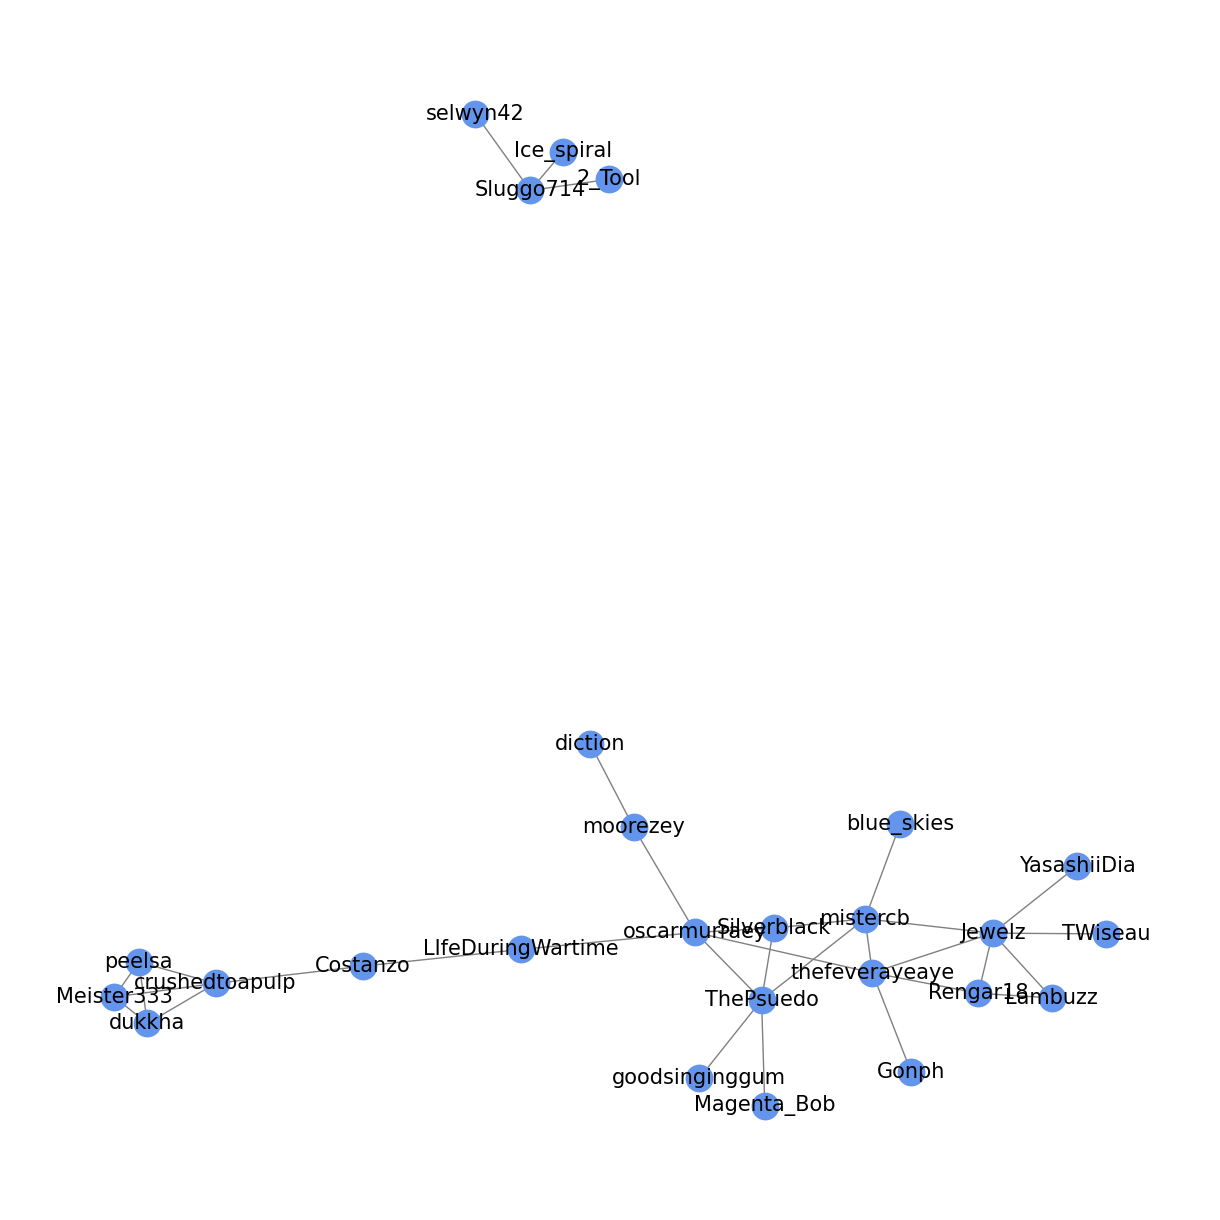

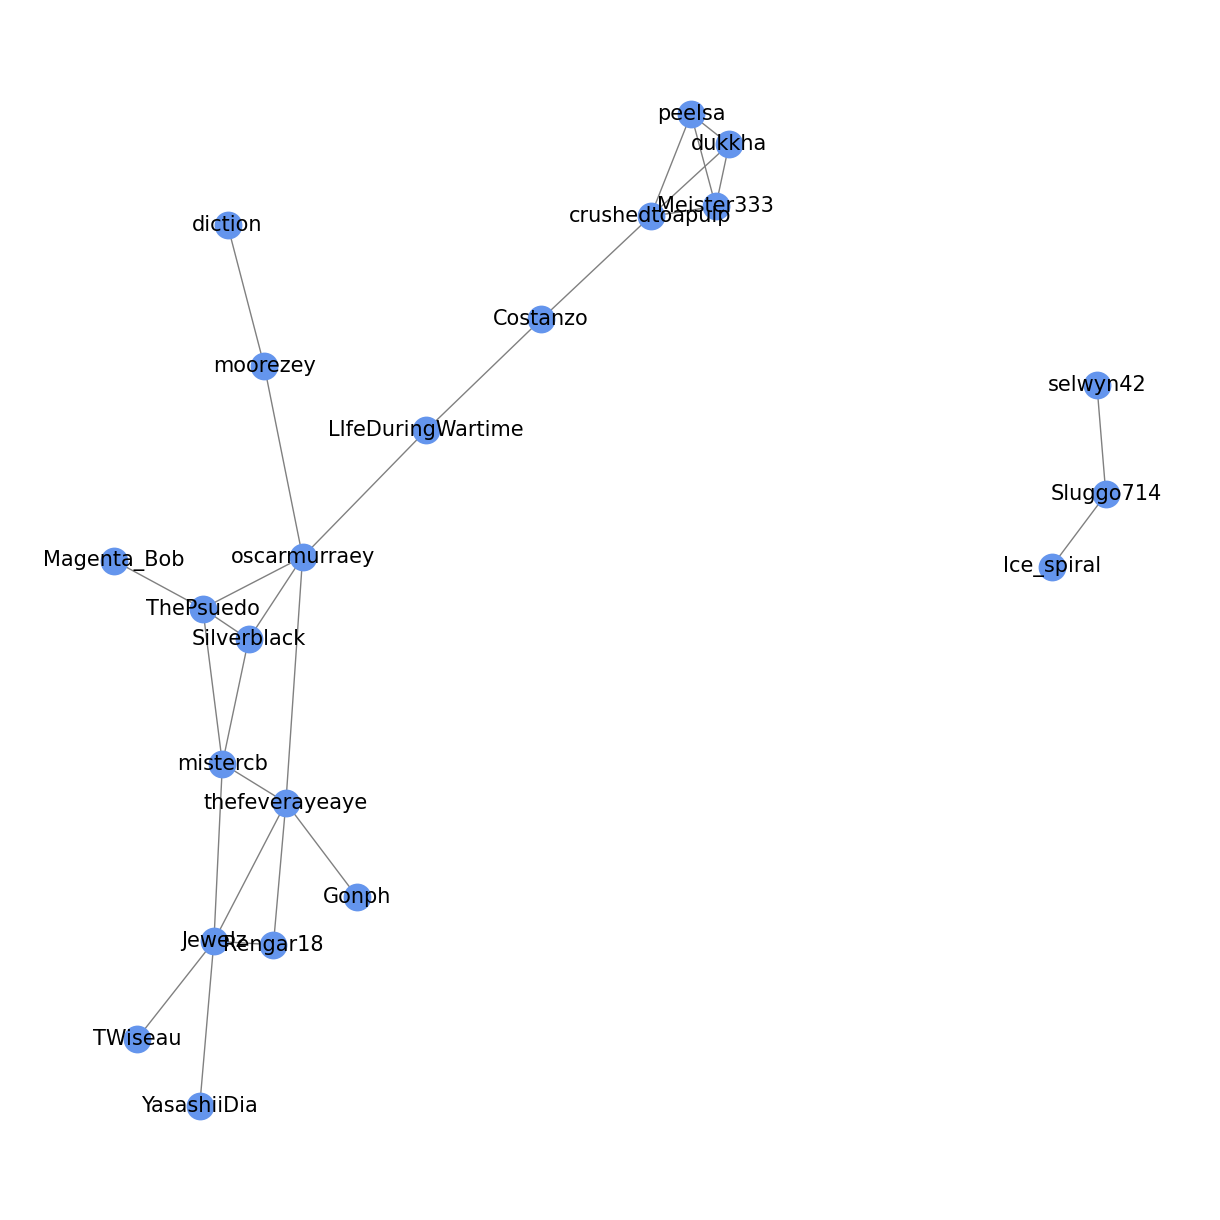

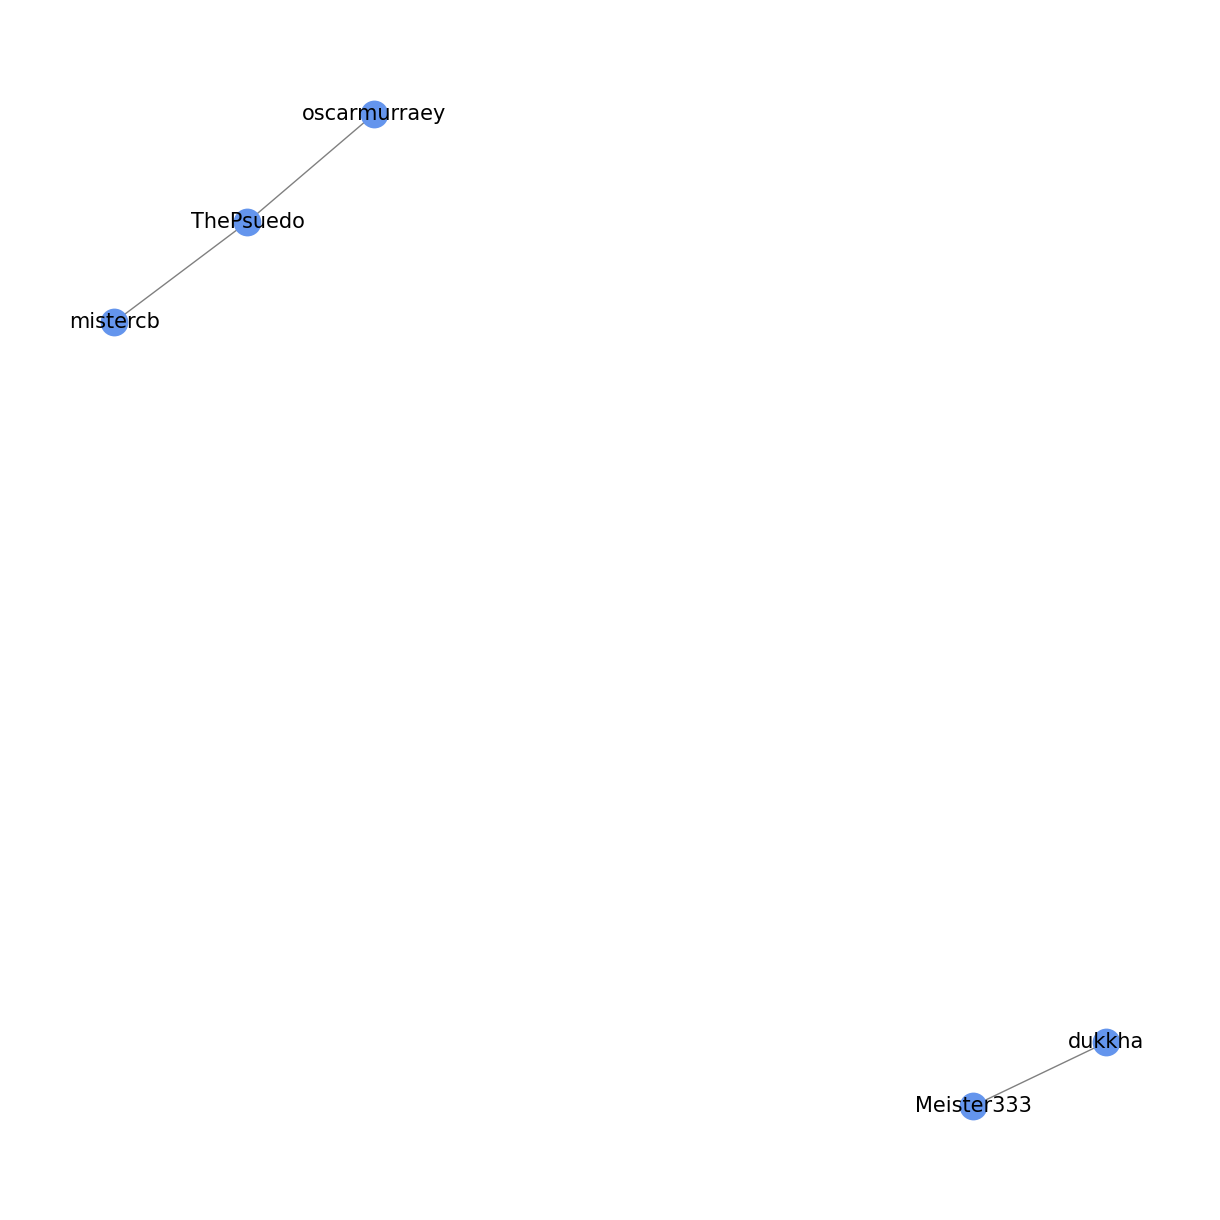

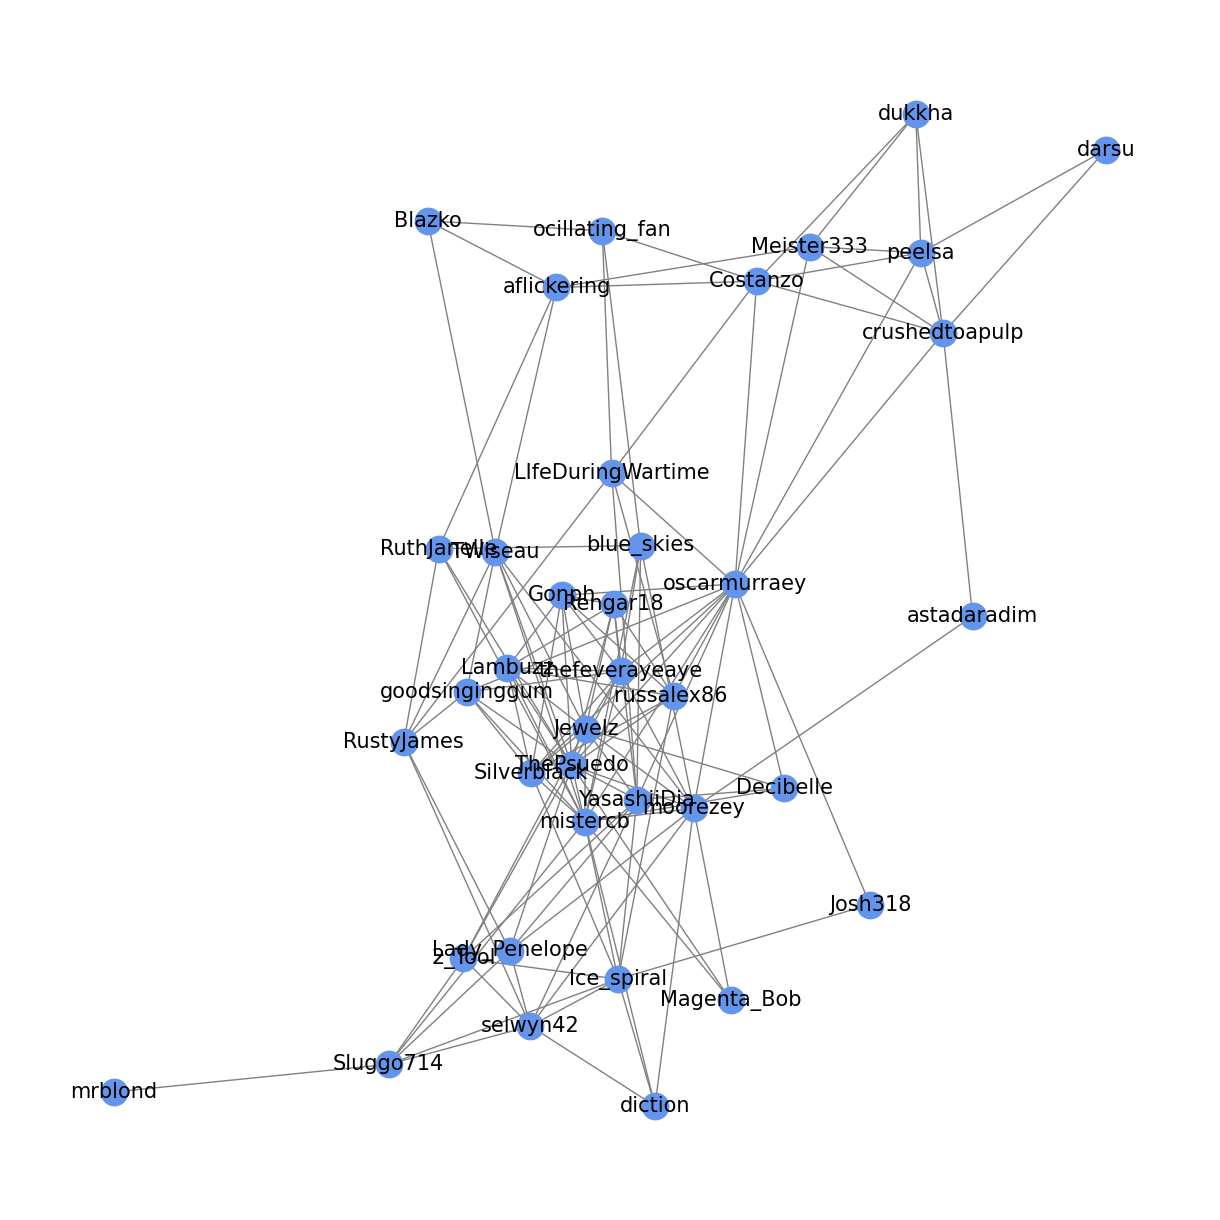

In [15]:
# @markdown

import networkx as nx

def display_df_net(Dataset, Plot, Width, Height, Thresh, SelfCorr):

  observe_data_selection_w4_max_corr(data_selection_w4, 'value')
  cc = cc_dict[Dataset]
  links = cc.links_ranked

  # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
  links_filtered=links.loc[links['value'] > Thresh]
  if not SelfCorr:
    links_filtered=links_filtered.loc[links_filtered['var1'] != links_filtered['var2']]

  # Build graph
  G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

  plt.figure(1,figsize=(Width,Height))

  if Plot == "Default":
    nx.draw(G, with_labels=True, node_color='cornflowerblue', node_size=400, edge_color='grey', linewidths=0.01, font_size=15, font_color="black")
  elif Plot == "Kamada-Kawai":
    nx.draw_kamada_kawai(G, with_labels=True, node_color='cornflowerblue', node_size=400, edge_color='grey', linewidths=0.01, font_size=15, font_color="black")
  elif Plot == "Circular":
    nx.draw_circular(G, with_labels=True, node_color='cornflowerblue', node_size=400, edge_color='grey', linewidths=0.01, font_size=15, font_color="black")


startset = list(cc_dict.keys())[0]
start_vmc = cc_dict[startset].vmc_ranked
MAX_CORRELATION = round(start_vmc[start_vmc<1].max().max(), 2)
for cc in cc_dict: cc_dict[cc].set_links()

# Widgets
layout={'width': '350px'}
net_w = widgets.Dropdown(options=["Default","Kamada-Kawai","Circular"], value="Default", description='Network:', disabled=False)
width_w = widgets.IntSlider(min=5, max=40, step=1, layout=layout, value=12,description='Width:')
height_w = widgets.IntSlider(min=5, max=40, step=1, layout=layout, value=12,description='Height:')
thresh_w = widgets.FloatSlider(min=0, max=MAX_CORRELATION, step=0.01, layout=layout, value=2*MAX_CORRELATION/3,description='Threshold:')
self_corr_w = widgets.Checkbox(value=False,description='Self-Correlation')

sel = list(cc_dict.keys())
sel.remove("Film (Combined)")
data_selection_w4 = widgets.Dropdown(options=sel, value=startset, description='Dataset:', disabled=False)

def observe_data_selection_w4_max_corr(*args):
  """Adjust available voters when changing dataset"""
  dataset = data_selection_w4.value
  vmc = cc_dict[dataset].vmc_ranked
  thresh_w.max = round(vmc[vmc<1].max().max(), 2)

ws_net = [data_selection_w4,net_w,width_w,height_w,thresh_w] #self_corr_w

out_net = widgets.interactive_output(display_df_net,{'Dataset':data_selection_w4,'Plot':net_w,'Width':width_w,'Height':height_w,'Thresh':thresh_w,'SelfCorr':self_corr_w})
ui_net = widgets.GridBox(ws_net, layout=widgets.Layout(grid_template_columns="repeat(2, 400px)"))

display(ui_net, out_net)

# Poll Information

The "Diff." column in all previous dataframes indicates the difference in ranking between the currently active chart and the default chart.

---
##### **Film Board Ranks the Decades of Cinema: 2010s**

Hosted by diction

[RYM List](https://rateyourmusic.com/list/diction/rym-ranks-the-decades-of-cinema-2010s-2021_final-edition/) | [Google Sheet](https://docs.google.com/spreadsheets/d/1zupC7TiE05DorhO7Og2lgCqGw60T-jv9souNf6PlS14/edit?usp=sharing)

Started: 12. January 2021<br>
Closed: 14. February 2021

Default Chart: Classic (Borda count $\times$ number of votes)

I included Decibelle's list this compilation, but not Xetfield's (as it was unlinked). I also updated my own list. :p

---
##### **Film Board Ranks the Decades of Cinema: 2000s**

Hosted by Rengar18

[RYM List](https://rateyourmusic.com/list/Rengar18/film-board-ranks-the-decades-of-cinema-2000s/) | [Google Sheet](https://docs.google.com/spreadsheets/d/1n93oIpYzbh7eWmzfR4_BR9nWrciyrIvXP2XiSEWQw-Y/edit?usp=sharing)

Started: 28. October 2021<br>
Closed: 28. November 2021

Default Chart: Classic (Borda count $\times$ number of votes)

---
##### **Film Board Ranks the Decades of Cinema: 1990s**

Hosted by Rengar18

[RYM List](https://rateyourmusic.com/list/Rengar18/film-board-ranks-the-decades-of-cinema-1990s/) | [Google Sheet](https://docs.google.com/spreadsheets/d/1HCwzUm-tGeFFxnbTu5NwXoVKKCyf4p9Di8U1w9hTI1I/edit?usp=sharing)

Started: 7. December 2021<br>
Closed: 1. February 2022

Default Chart: Classic (Borda count $\times$ number of votes)

---
##### **Film Board Ranks the Decades of Cinema: 1980s**

Hosted by Rengar18

[RYM List](https://rateyourmusic.com/list/Rengar18/film-board-ranks-the-decades-of-cinema-1980s/) | [Google Sheet](https://docs.google.com/spreadsheets/d/1tMDLNq7-pJgJe8B5kHB8453KpP4I8_XXHm_tuSml_4Q/edit?usp=sharing)

Started: 4. February 2022<br>
Closed: 2. May 2022

Default Chart: Classic (Borda count $\times$ number of votes)

---
##### **Film Board Ranks the Decades of Cinema: 1980s - 2010s**


The combined results from all decade polls. Note that both the votes and the scores are weighted to adjust for differences in voter turnout between the polls. That is, the votes/scores from the individual decade polls are mutliplied by the following weights:

1980s: 1.0<br>
1990s: 1.05<br>
2000s: 1.38<br>
2010s: 2.22<br>

Default Chart: Classic (Borda count $\times$ number of votes)

---

Default Chart: Size-dependent Borda count. Maximum ballot size is 50. Ranked, partially ranked and unranked ballot allowed. For a ballot of length $n$ where the first $m$ elements are ranked, the point distribution for a show in position $p$ is as follows:

$\begin{split}
  \textrm{Points} &= n - p +1 & \quad \textrm{for} \quad p ≤ m,\\
  \textrm{Points} &= \frac{1}{2} (n - m + 1) & \quad \textrm{for} \quad p > m
\end{split}$

